In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [70]:
TRAIN_DF = '../input/humpback-whale-identification/train.csv'
SUB_Df = '../input/humpback-whale-identification/sample_submission.csv'
TRAIN = '../input/humpback-whale-identification/train/'
TEST = '../input/humpback-whale-identification/test/'
P2H = '../input/metadata/p2h.pickle'
P2SIZE = '../input/metadata/p2size.pickle'
BB_DF = "../input/metadata/bounding_boxes.csv"


In [71]:
!pip install lap
from pandas import read_csv
tagged = dict([(p, w) for _, p, w in read_csv(TRAIN_DF).to_records()])
submit = [p for _, p, _ in read_csv(SUB_Df).to_records()]
join = list(tagged.keys()) + submit
len(tagged),len(submit),len(join),list(tagged.items())[:5],submit[:5]

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


(25361,
 7960,
 33321,
 [('0000e88ab.jpg', 'w_f48451c'),
  ('0001f9222.jpg', 'w_c3d896a'),
  ('00029d126.jpg', 'w_20df2c5'),
  ('00050a15a.jpg', 'new_whale'),
  ('0005c1ef8.jpg', 'new_whale')],
 ['00028a005.jpg',
  '000dcf7d8.jpg',
  '000e7c7df.jpg',
  '0019c34f4.jpg',
  '001a4d292.jpg'])

In [72]:
from os.path import isfile
from PIL import Image as pil_image
from tqdm import tqdm_notebook as tqdm
def expand_path(p):
    if isfile(TRAIN + p):
        return TRAIN + p
    if isfile(TEST + p):
        return TEST + p
    return p

In [73]:
import gzip
import pickle
from lap import lapjv
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imagehash import phash
from keras.utils import Sequence
import time

In [74]:
import platform
import random
import keras
import sys
from scipy.ndimage import affine_transform
from keras import backend as K
from keras.preprocessing.image import img_to_array,array_to_img

In [75]:
def show_whale(imgs, per_row=2):
    n = len(imgs)
    rows = (n + per_row - 1) // per_row
    cols = min(per_row, n)
    fig, axes = plt.subplots(rows, cols, figsize=(24 // per_row * cols, 24 // per_row * rows))
    for ax in axes.flatten(): ax.axis('off')
    for i, (img, ax) in enumerate(zip(imgs, axes.flatten())): ax.imshow(img.convert('RGB'))

#returns the image we need
def read_raw_image(p):
    img = pil_image.open(expand_path(p))
    return img

In [76]:
with open(P2H, 'rb') as f:
    p2h = pickle.load(f)
h2ps = {}
for p, h in p2h.items():
    if h not in h2ps: h2ps[h] = []
    if p not in h2ps[h]: h2ps[h].append(p)
with open(P2SIZE, 'rb') as f:
    p2size = pickle.load(f)
p2bb = pd.read_csv(BB_DF).set_index("Image")
old_stderr = sys.stderr
sys.stderr = open('/dev/null' if platform.system() != 'Windows' else 'nul', 'w')
sys.stderr = old_stderr
img_shape = (384, 384, 1)
anisotropy = 2.15
crop_margin = 0.1  

In [77]:
def prefer(ps):
    if len(ps) == 1: return ps[0]
    best_p = ps[0]
    best_s = p2size[best_p]
    for i in range(1, len(ps)):
        p = ps[i]
        s = p2size[p]
        if s[0] * s[1] > best_s[0] * best_s[1]: 
            best_p = p
            best_s = s
    return best_p

h2p = {}
for h, ps in h2ps.items():
    h2p[h] = prefer(ps)
len(h2p), list(h2p.items())[:5]

(33317,
 [('d26698c3271c757c', '0000e88ab.jpg'),
  ('ba8cc231ad489b77', '0001f9222.jpg'),
  ('bbcad234a52d0f0b', '00029d126.jpg'),
  ('c09ae7dc09f33a29', '00050a15a.jpg'),
  ('d02f65ba9f74a08a', '0005c1ef8.jpg')])

In [78]:
def build_transform(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):

    rotation = np.deg2rad(rotation)
    shear = np.deg2rad(shear)
    rotation_matrix = np.array(
        [[np.cos(rotation), np.sin(rotation), 0], [-np.sin(rotation), np.cos(rotation), 0], [0, 0, 1]])
    shift_matrix = np.array([[1, 0, height_shift], [0, 1, width_shift], [0, 0, 1]])
    shear_matrix = np.array([[1, np.sin(shear), 0], [0, np.cos(shear), 0], [0, 0, 1]])
    zoom_matrix = np.array([[1.0 / height_zoom, 0, 0], [0, 1.0 / width_zoom, 0], [0, 0, 1]])
    shift_matrix = np.array([[1, 0, -height_shift], [0, 1, -width_shift], [0, 0, 1]])
    return np.dot(np.dot(rotation_matrix, shear_matrix), np.dot(zoom_matrix, shift_matrix))

In [79]:
def read_cropped_image(p, augment):

    # If an image id was given, convert to filename
    if p in h2p:
        p = h2p[p]
    size_x, size_y = p2size[p]

    # Determine the region of the original image we want to capture based on the bounding box.
    row = p2bb.loc[p]
    x0, y0, x1, y1 = row['x0'], row['y0'], row['x1'], row['y1']
    dx = x1 - x0
    dy = y1 - y0
    x0 -= dx * crop_margin
    x1 += dx * crop_margin + 1
    y0 -= dy * crop_margin
    y1 += dy * crop_margin + 1
    if x0 < 0:
        x0 = 0
    if x1 > size_x:
        x1 = size_x
    if y0 < 0:
        y0 = 0
    if y1 > size_y:
        y1 = size_y
    dx = x1 - x0
    dy = y1 - y0
    if dx > dy * anisotropy:
        dy = 0.5 * (dx / anisotropy - dy)
        y0 -= dy
        y1 += dy
    else:
        dx = 0.5 * (dy * anisotropy - dx)
        x0 -= dx
        x1 += dx

    # Generate the transformation matrix randomly
    trans = np.array([[1, 0, -0.5 * img_shape[0]], [0, 1, -0.5 * img_shape[1]], [0, 0, 1]])
    trans = np.dot(np.array([[(y1 - y0) / img_shape[0], 0, 0], [0, (x1 - x0) / img_shape[1], 0], [0, 0, 1]]), trans)
    if augment:
        trans = np.dot(build_transform(
            random.uniform(-5, 5),
            random.uniform(-5, 5),
            random.uniform(0.8, 1.0),
            random.uniform(0.8, 1.0),
            random.uniform(-0.05 * (y1 - y0), 0.05 * (y1 - y0)),
            random.uniform(-0.05 * (x1 - x0), 0.05 * (x1 - x0))
        ), trans)
    trans = np.dot(np.array([[1, 0, 0.5 * (y1 + y0)], [0, 1, 0.5 * (x1 + x0)], [0, 0, 1]]), trans)

    # Read the image, transform to black and white and convert to numpy array
    img = read_raw_image(p).convert('L')
    img = img_to_array(img)

    # Apply affine transformation
    matrix = trans[:2, :2]
    offset = trans[:2, 2]
    img = img.reshape(img.shape[:-1])
    img = affine_transform(img, matrix, offset, output_shape=img_shape[:-1], order=1, mode='constant',
                           cval=np.average(img))
    img = img.reshape(img_shape)

    # Normalize to zero mean and unit variance
    img -= np.mean(img, keepdims=True)
    img /= np.std(img, keepdims=True) + K.epsilon()
    return img

In [80]:
from keras import regularizers
from keras.engine.topology import Input
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, GlobalMaxPooling2D, \
    Lambda, MaxPooling2D, Reshape
from keras.models import Model
from keras.optimizers import Adam


In [81]:
def subblock(x, filter, **kwargs):
    x = BatchNormalization()(x)
    y = x
    y = Conv2D(filter, (1, 1), activation='relu', **kwargs)(y)  # Reduce the number of features to 'filter'
    y = BatchNormalization()(y)
    y = Conv2D(filter, (3, 3), activation='relu', **kwargs)(y)  # Extend the feature field
    y = BatchNormalization()(y)
    y = Conv2D(K.int_shape(x)[-1], (1, 1), **kwargs)(y)  # no activation # Restore the number of original features
    y = Add()([x, y])  # Add the bypass connection
    y = Activation('relu')(y)
    return y

#The branch model of the Siamese Nueral Network is a normal CNN
#We perform the CNN to get the images into vectors so that they can be compared during the head branch
def build_model(lr, l2, activation='sigmoid'):
    
    # BRANCH MODEL
    
    regul = regularizers.l2(l2)
    optim = Adam(lr=lr)
    kwargs = {'padding': 'same', 'kernel_regularizer': regul}

    inp = Input(shape=img_shape) 
    x = Conv2D(64, (9, 9), strides=2, activation='relu', **kwargs)(inp)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) 
    for _ in range(2):
        x = BatchNormalization()(x)
        x = Conv2D(64, (3, 3), activation='relu', **kwargs)(x)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) 
    x = BatchNormalization()(x)
    x = Conv2D(128, (1, 1), activation='relu', **kwargs)(x)  
    for _ in range(4):
        x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  
    x = BatchNormalization()(x)
    x = Conv2D(256, (1, 1), activation='relu', **kwargs)(x)  
    for _ in range(4):
        x = subblock(x, 64, **kwargs)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  
    x = BatchNormalization()(x)
    x = Conv2D(384, (1, 1), activation='relu', **kwargs)(x)  
    for _ in range(4):
        x = subblock(x, 96, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  
    x = BatchNormalization()(x)
    x = Conv2D(512, (1, 1), activation='relu', **kwargs)(x)  
    for _ in range(4):
        x = subblock(x, 128, **kwargs)

    x = GlobalMaxPooling2D()(x)  # 512
    branch_model = Model(inp, x)

   
    # HEAD MODEL
 
    mid = 32
    xa_inp = Input(shape=branch_model.output_shape[1:])
    xb_inp = Input(shape=branch_model.output_shape[1:])
    x1 = Lambda(lambda x: x[0] * x[1])([xa_inp, xb_inp])
    x2 = Lambda(lambda x: x[0] + x[1])([xa_inp, xb_inp])
    x3 = Lambda(lambda x: K.abs(x[0] - x[1]))([xa_inp, xb_inp])
    x4 = Lambda(lambda x: K.square(x))(x3)
    x = Concatenate()([x1, x2, x3, x4])
    x = Reshape((4, branch_model.output_shape[1], 1), name='reshape1')(x)

    # Per feature NN with shared weight is implemented using CONV2D with appropriate stride.
    x = Conv2D(mid, (4, 1), activation='relu', padding='valid')(x)
    x = Reshape((branch_model.output_shape[1], mid, 1))(x)
    x = Conv2D(1, (1, mid), activation='linear', padding='valid')(x)
    x = Flatten(name='flatten')(x)

    # Weighted sum implemented as a Dense layer.
    x = Dense(1, use_bias=True, activation=activation, name='weighted-average')(x)
    head_model = Model([xa_inp, xb_inp], x, name='head')
    
    
    # SIAMESE NEURAL NETWORK
   
    img_a = Input(shape=img_shape)
    img_b = Input(shape=img_shape)
    xa = branch_model(img_a) 
    xb = branch_model(img_b) 
    x = head_model([xa, xb]) 
    model = Model([img_a, img_b], x)
    model.compile(optim, loss='binary_crossentropy', metrics=['binary_crossentropy', 'acc'])
    return model, branch_model, head_model


model, branch_model, head_model = build_model(64e-5, 0)
head_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 512)          0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           (None, 512)          0                                            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 512)          0           input_12[0][0]                   
                                                                 input_13[0][0]                   
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 512)          0           input_12[0][0]                   
          

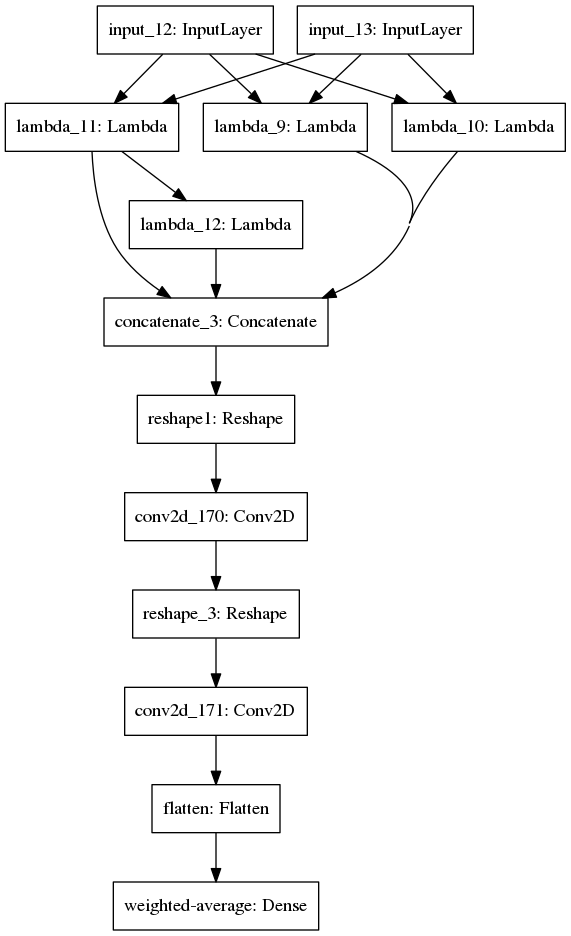

In [82]:
from keras.utils import plot_model
plot_model(head_model, to_file='head-model.png')
pil_image.open('head-model.png')

In [83]:
h2ws = {}
new_whale = 'new_whale'
for p, w in tagged.items():
    if w != new_whale:  
        h = p2h[p]
        if h not in h2ws: h2ws[h] = []
        if w not in h2ws[h]: h2ws[h].append(w)
for h, ws in h2ws.items():
    if len(ws) > 1:
        h2ws[h] = sorted(ws)

w2hs = {}
for h, ws in h2ws.items():
    if len(ws) == 1:  # Use only unambiguous pictures
        w = ws[0]
        if w not in w2hs: w2hs[w] = []
        if h not in w2hs[w]: w2hs[w].append(h)
for w, hs in w2hs.items():
    if len(hs) > 1:
        w2hs[w] = sorted(hs)

In [84]:
train = []  # A list of training image ids
for hs in w2hs.values():
    if len(hs) > 1:
        train += hs
random.shuffle(train)
train_set = set(train)

w2ts = {}  # Associate the image ids from train to each whale id.
for w, hs in w2hs.items():
    for h in hs:
        if h in train_set:
            if w not in w2ts:
                w2ts[w] = []
            if h not in w2ts[w]:
                w2ts[w].append(h)
for w, ts in w2ts.items():
    w2ts[w] = np.array(ts)

t2i = {}  # The position in train of each training image id
for i, t in enumerate(train):
    t2i[t] = i

In [85]:
try:
    from lap import lapjv
    segment = False
except ImportError:
    print('Module lap not found, emulating with much slower scipy.optimize.linear_sum_assignment')
    segment = True
    from scipy.optimize import linear_sum_assignment
class TrainingData(Sequence):
    def __init__(self, score, steps=1000, batch_size=32):
        """
        @param score the cost matrix for the picture matching
        @param steps the number of epoch we are planning with this score matrix
        """
        super(TrainingData, self).__init__()
        self.score = -score  # Maximizing the score is the same as minimuzing -score.
        self.steps = steps
        self.batch_size = batch_size
        for ts in w2ts.values():
            idxs = [t2i[t] for t in ts]
            for i in idxs:
                for j in idxs:
                    self.score[
                        i, j] = 10000.0  # Set a large value for matching whales -- eliminates this potential pairing
        self.on_epoch_end()

    def __getitem__(self, index):
        start = self.batch_size * index
        end = min(start + self.batch_size, len(self.match) + len(self.unmatch))
        size = end - start
        assert size > 0
        a = np.zeros((size,) + img_shape, dtype=K.floatx())
        b = np.zeros((size,) + img_shape, dtype=K.floatx())
        c = np.zeros((size, 1), dtype=K.floatx())
        j = start // 2
        for i in range(0, size, 2):
            a[i, :, :, :] = read_for_training(self.match[j][0])
            b[i, :, :, :] = read_for_training(self.match[j][1])
            c[i, 0] = 1  # This is a match
            a[i + 1, :, :, :] = read_for_training(self.unmatch[j][0])
            b[i + 1, :, :, :] = read_for_training(self.unmatch[j][1])
            c[i + 1, 0] = 0  # Different whales
            j += 1
        return [a, b], c

    def on_epoch_end(self):
        if self.steps <= 0: return  # Skip this on the last epoch.
        self.steps -= 1
        self.match = []
        self.unmatch = []
        _, _, x = lapjv(self.score)  # Solve the linear assignment problem
        y = np.arange(len(x), dtype=np.int32)

        # Compute a derangement for matching whales
        for ts in w2ts.values():
            d = ts.copy()
            while True:
                random.shuffle(d)
                if not np.any(ts == d): break
            for ab in zip(ts, d): self.match.append(ab)

        # Construct unmatched whale pairs from the LAP solution.
        for i, j in zip(x, y):
            if i == j:
                print(self.score)
                print(x)
                print(y)
                print(i, j)
            assert i != j
            self.unmatch.append((train[i], train[j]))

        # Force a different choice for an eventual next epoch.
        self.score[x, y] = 10000.0
        self.score[y, x] = 10000.0
        random.shuffle(self.match)
        random.shuffle(self.unmatch)
        # print(len(self.match), len(train), len(self.unmatch), len(train))
        assert len(self.match) == len(train) and len(self.unmatch) == len(train)

    def __len__(self):
        return (len(self.match) + len(self.unmatch) + self.batch_size - 1) // self.batch_size

In [86]:
def read_for_training(p):
    """
    Read and preprocess an image with data augmentation (random transform).
    """
    return read_cropped_image(p, True)

def read_for_validation(p):
    """
    Read and preprocess an image without data augmentation (use for testing).
    """
    return read_cropped_image(p, False)

In [87]:
score = np.random.random_sample(size=(len(train), len(train)))
data = TrainingData(score)
(a, b), c = data[0]
a.shape, b.shape, c.shape

((32, 384, 384, 1), (32, 384, 384, 1), (32, 1))

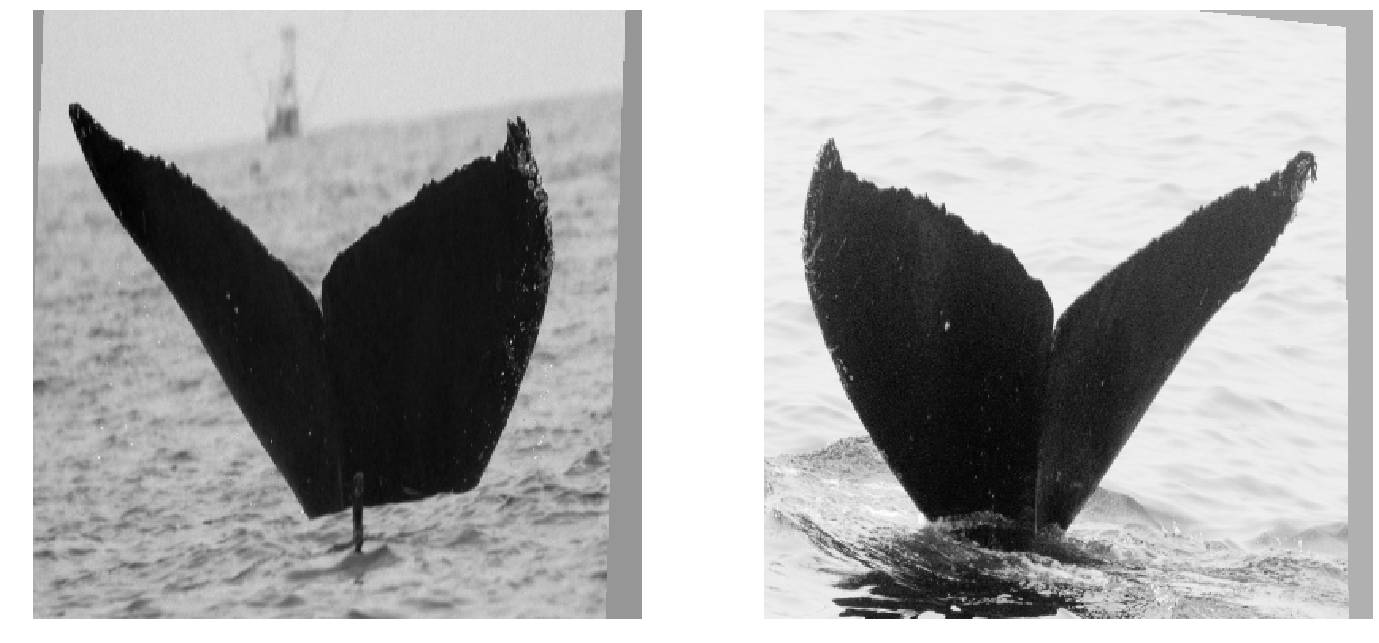

In [96]:
# First pair is for matching whale
imgs = [array_to_img(a[2]), array_to_img(b[2])]
show_whale(imgs, per_row=2)

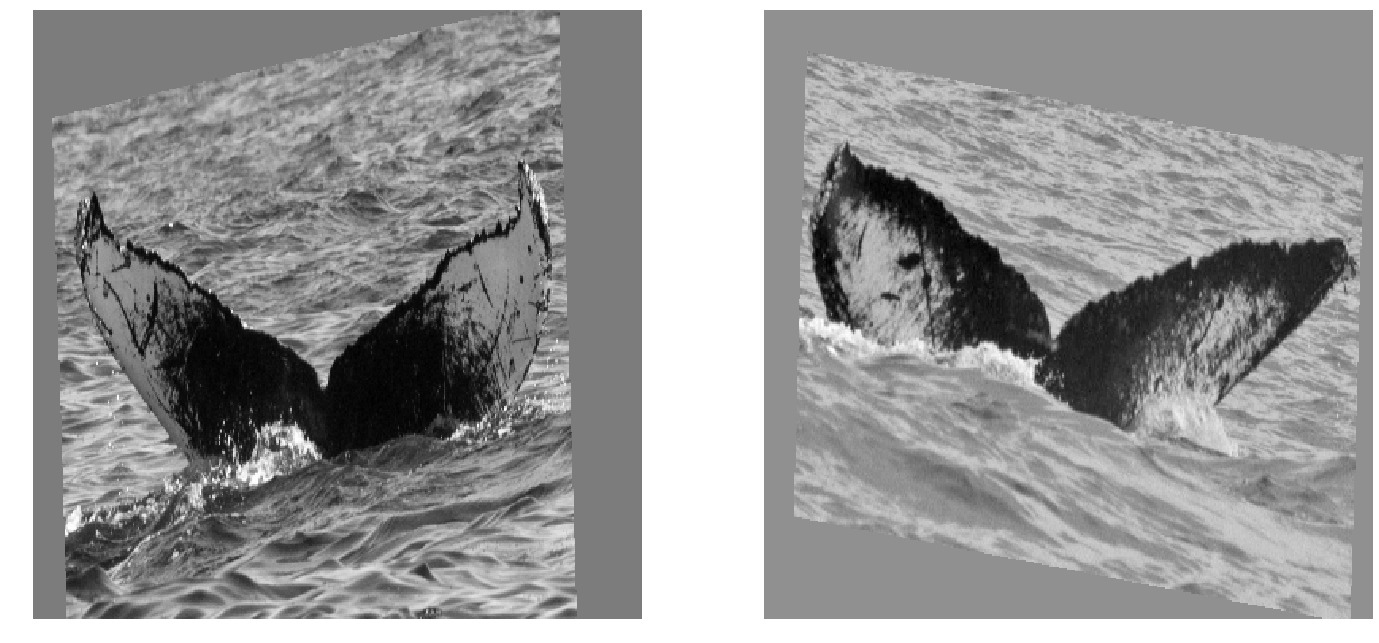

In [97]:
# First pair is for not matching whale
imgs = [array_to_img(a[3]), array_to_img(b[3])]
show_whale(imgs, per_row=2)

In [90]:
#These are used to calculate the scores of the CNN on the training set
# A Keras generator to evaluate only the BRANCH MODEL
class FeatureGen(Sequence):
    def __init__(self, data, batch_size=64, verbose=1):
        super(FeatureGen, self).__init__()
        self.data = data
        self.batch_size = batch_size
        self.verbose = verbose
        if self.verbose > 0: self.progress = tqdm(total=len(self), desc='Features')

    def __getitem__(self, index):
        start = self.batch_size * index
        size = min(len(self.data) - start, self.batch_size)
        a = np.zeros((size,) + img_shape, dtype=K.floatx())
        for i in range(size): a[i, :, :, :] = read_for_validation(self.data[start + i])
        if self.verbose > 0:
            self.progress.update()
            if self.progress.n >= len(self): self.progress.close()
        return a

    def __len__(self):
        return (len(self.data) + self.batch_size - 1) // self.batch_size
    
# A Keras generator to evaluate on the HEAD MODEL on features already pre-computed.
# It computes only the upper triangular matrix of the cost matrix if y is None.
class ScoreGen(Sequence):
    def __init__(self, x, y=None, batch_size=2048, verbose=1):
        super(ScoreGen, self).__init__()
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.verbose = verbose
        if y is None:
            self.y = self.x
            self.ix, self.iy = np.triu_indices(x.shape[0], 1)
        else:
            self.iy, self.ix = np.indices((y.shape[0], x.shape[0]))
            self.ix = self.ix.reshape((self.ix.size,))
            self.iy = self.iy.reshape((self.iy.size,))
        self.subbatch = (len(self.x) + self.batch_size - 1) // self.batch_size
        if self.verbose > 0:
            self.progress = tqdm(total=len(self), desc='Scores')

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min(start + self.batch_size, len(self.ix))
        a = self.y[self.iy[start:end], :]
        b = self.x[self.ix[start:end], :]
        if self.verbose > 0:
            self.progress.update()
            if self.progress.n >= len(self): self.progress.close()
        return [a, b]

    def __len__(self):
        return (len(self.ix) + self.batch_size - 1) // self.batch_size

In [91]:
def set_lr(model, lr):
    K.set_value(model.optimizer.lr, float(lr))

def get_lr(model):
    return K.get_value(model.optimizer.lr)

In [92]:
#converting the upper triangular matrix into a square matrix
def score_reshape(score, x, y=None):

    if y is None:
        # When y is None, score is a packed upper triangular matrix.
        # Unpack, and transpose to form the symmetrical lower triangular matrix.
        m = np.zeros((x.shape[0], x.shape[0]), dtype=K.floatx())
        m[np.triu_indices(x.shape[0], 1)] = score.squeeze()
        m += m.transpose()
    else:
        m = np.zeros((y.shape[0], x.shape[0]), dtype=K.floatx())
        iy, ix = np.indices((y.shape[0], x.shape[0]))
        ix = ix.reshape((ix.size,))
        iy = iy.reshape((iy.size,))
        m[iy, ix] = score.squeeze()
    return m

In [93]:
#use the FeatureGen and the ScoreGen to calculate the score for our trained models
def compute_score(verbose=1):

    features = branch_model.predict_generator(FeatureGen(train, verbose=verbose), max_queue_size=12, workers=6,
                                              verbose=0)
    score = head_model.predict_generator(ScoreGen(features, verbose=verbose), max_queue_size=12, workers=6, verbose=0)
    score = score_reshape(score, features)
    return features, score

In [94]:
def make_steps(step, ampl):
    global w2ts, t2i, steps, features, score, histories
    random.shuffle(train)

    w2ts = {}
    for w, hs in w2hs.items():
        for h in hs:
            if h in train_set:
                if w not in w2ts: w2ts[w] = []
                if h not in w2ts[w]: w2ts[w].append(h)
    for w, ts in w2ts.items(): w2ts[w] = np.array(ts)

    # Map training picture hash value to index in 'train' array    
    t2i = {}
    for i, t in enumerate(train): t2i[t] = i

    # Compute the match score for each picture pair
    features, score = compute_score()

    # Train the model for 'step' epochs
    history = model.fit_generator(
        TrainingData(score + ampl * np.random.random_sample(size=score.shape), steps=step, batch_size=32),
        initial_epoch=steps, epochs=steps + step, max_queue_size=12, workers=6, verbose=1).history
    steps += step

    # Collect history data
    history['epochs'] = steps
    history['ms'] = np.mean(score)
    history['lr'] = get_lr(model)
    print(history['epochs'], history['lr'], history['ms'])
    histories.append(history)

In [95]:
histories = []
steps = 0
tmp = keras.models.load_model('../input/piotte/mpiotte-standard.model')
model.set_weights(tmp.get_weights())
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 384, 384, 1)  0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 384, 384, 1)  0                                            
__________________________________________________________________________________________________
model_5 (Model)                 (None, 512)          2692096     input_14[0][0]                   
                                                                 input_15[0][0]                   
__________________________________________________________________________________________________
head (Model)                    (None, 1)            706         model_5[1][0]                    
          

In [ ]:
def prepare_submission(threshold, filename):

    vtop = 0
    vhigh = 0
    pos = [0, 0, 0, 0, 0, 0]
    with open(filename, 'wt', newline='\n') as f:
        f.write('Image,Id\n')
        for i, p in enumerate(tqdm(submit)):
            t = []
            s = set()
            a = score[i, :]
            for j in list(reversed(np.argsort(a))):
                h = known[j]
                if a[j] < threshold and new_whale not in s:
                    pos[len(t)] += 1
                    s.add(new_whale)
                    t.append(new_whale)
                    if len(t) == 5: break;
                for w in h2ws[h]:
                    assert w != new_whale
                    if w not in s:
                        if a[j] > 1.0:
                            vtop += 1
                        elif a[j] >= threshold:
                            vhigh += 1
                        s.add(w)
                        t.append(w)
                        if len(t) == 5: break;
                if len(t) == 5: break;
            if new_whale not in s: pos[5] += 1
            assert len(t) == 5 and len(s) == 5
            f.write(p + ',' + ' '.join(t[:5]) + '\n')
    return vtop, vhigh, pos

tic = time.time()
h2ws = {}
for p, w in tagged.items():
    if w != new_whale:  # Use only identified whales
        h = p2h[p]
        if h not in h2ws: h2ws[h] = []
        if w not in h2ws[h]: h2ws[h].append(w)
known = sorted(list(h2ws.keys()))

# Dictionary of picture indices
h2i = {}
for i, h in enumerate(known): h2i[h] = i

# Evaluate the model.
fknown = branch_model.predict_generator(FeatureGen(known), max_queue_size=20, workers=10, verbose=0)
fsubmit = branch_model.predict_generator(FeatureGen(submit), max_queue_size=20, workers=10, verbose=0)
score = head_model.predict_generator(ScoreGen(fknown, fsubmit), max_queue_size=20, workers=10, verbose=0)
score = score_reshape(score, fknown, fsubmit)


prepare_submission(0.99, 'submission.csv')
toc = time.time()